# Remote Sensing Analysis of Mangrove Forest in Baie de Grand-Pierre, Artibonite, Haiti

In [415]:
import os
import gc
import json
import glob
import tarfile
import pyproj
import math
import itertools

import cv2 as cv
import numpy as np
import xarray as xr
import rasterio as rs
import rioxarray as rxr
import pandas as pd
import earthpy.plot as ep
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from natsort import natsorted
from datetime import datetime
from matplotlib import colors as colors_mat
import matplotlib.patches as mpatches
import matplotlib.cm as cm

## AOI selection

In [416]:
aoi_list = ['coast_NW', 'coast_N', 'horn', 'coast_W', 'marsh_E', 'marsh_W']
#aoi_list = ['west','east','barrier', 'coast_marsh_S']

def aoi_path(name):
    return '../shapefiles/'+name+'.shp'

## PlanetLabs Data Analysis

### Planet Data GeoTIFFs acquisition

In [417]:
dir = '../Planet/'
#dir = '../Planet_Caracol/'
times = []
sites = []
resSites = []
unmasked_sites = []
for area in aoi_list:
    unmasked_obs = []
    obs = []
    res = []
    aoi = gpd.read_file(aoi_path(area))
    for entry in os.scandir(dir):
        times.append(entry.path)
        ob = rxr.open_rasterio(entry.path).rio.clip(aoi.geometry, from_disk=True).squeeze()
        ob_copy = rxr.open_rasterio(entry.path).rio.clip(aoi.geometry, from_disk=True).squeeze()
        res.append(ob.rio.resolution()[0])
        obs.append(ob)
        unmasked_obs.append(ob_copy)
    sites.append(obs)
    unmasked_sites.append(unmasked_obs)
    resSites.append(res)

## NDWI Masking

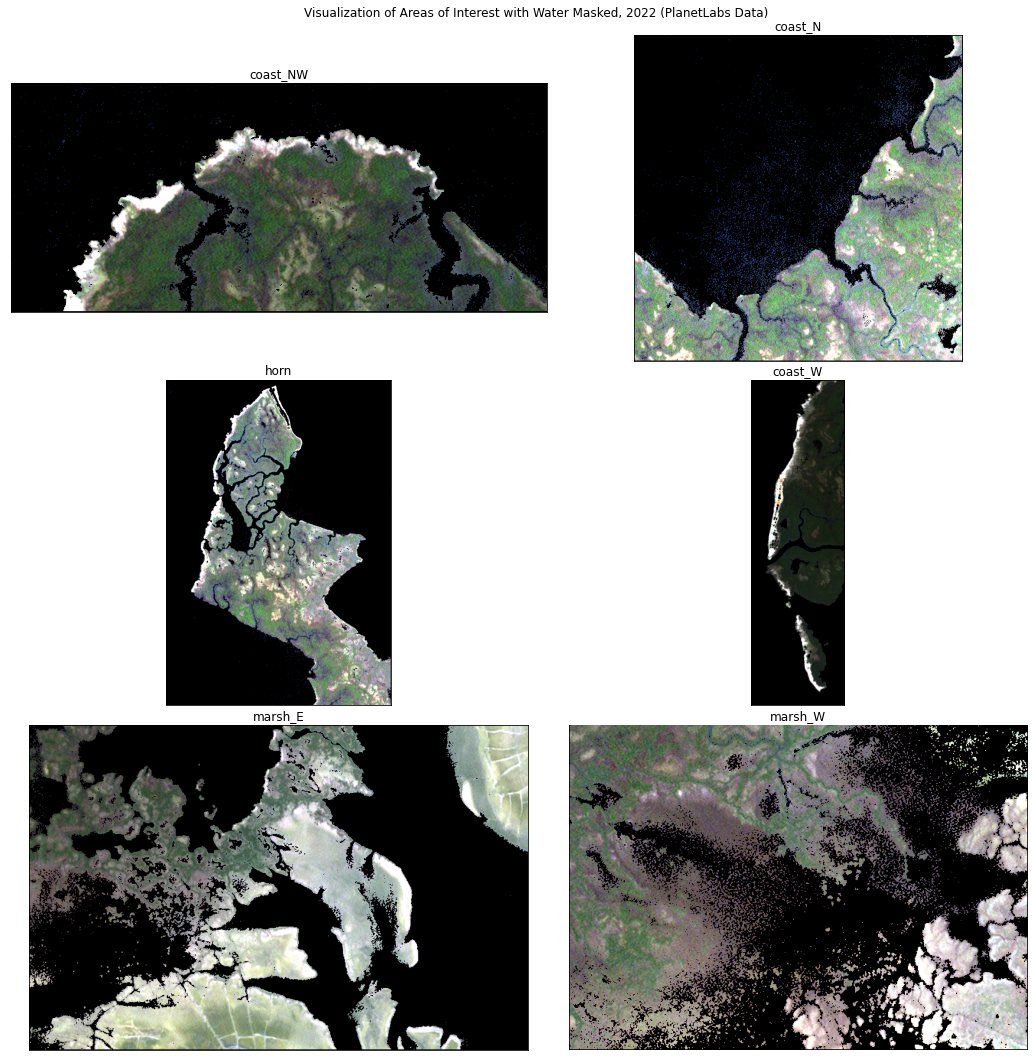

In [423]:
# NDWI = (green - nir)/(green + nir) McFeeters (1996)

#NDWI masks
ndwi_masks = []
for site in sites:
    for obs in site:
        try:
            ndwi = (obs[1]-obs[4])/(obs[1]+obs[4])
        except:
            ndwi = (obs[1]-obs[3])/(obs[1]+obs[3])
        ndwi_masks.append(ndwi)

# Masking water out of observations
count = 0
mask_count = 0
for site in sites:
    for i,obs in enumerate(site):
        for j,band in enumerate(obs):
            ### NDWI Masking Interpretation
            band = np.ma.masked_where(ndwi_masks[mask_count] > 0, band)
            obs[j] = np.nan_to_num(band)
            ###
            count+=1
            #obs[j] = np.nan_to_num(band)        
        mask_count+=1    

fig, axs = plt.subplots(3,2, figsize=(15,15))
fig.suptitle('Visualization of Areas of Interest with Water Masked, 2022 (PlanetLabs Data)')
axs = list(itertools.chain.from_iterable(axs))
for i, site in enumerate(sites):
    ep.plot_rgb(sites[i][0], rgb=[2,1,0], title=aoi_list[i], stretch=True,
            str_clip=1.5, ax=axs[i])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
plt.axis('off')
fig.patch.set_facecolor('xkcd:white')
plt.tight_layout(h_pad=0)

plt.show()


## Automated Coastline Detection

Data Reshaping into Vectors for ML use (Vectorizing bands for use in ML as they cant directly use matrices)

In [424]:
reshapedSites = []
for site in sites:
    acqVecs = []
    reshapedVecs = []
    shapes = []
    for ob in site:
        shapes.append(ob.shape)
        acq = [band.values.reshape(((band.shape)[0])*((band.shape)[1]), 1) for band in ob]
        acqVecs.append(acq)
    for i, acq in enumerate(acqVecs):
        resh = np.array(acq).reshape(shapes[i][0], shapes[i][1]*shapes[i][2]).transpose()
        reshapedVecs.append(resh)
    reshapedSites.append(reshapedVecs)

Segmentation and Clustering

In [425]:
reshapedSites[0][-1][:,3:].shape

(508872, 1)

In [426]:
# Segmenting through k-means
modelSites = []

#acquisitions = [planet]
print('Entering site...')
for reshapedVecs in tqdm(reshapedSites):
    models = []
    print('Fitting model...')
    # Excluding first 2 bands (blue and green) as mangroves do not pop out in them and they confuse the clustering
    for resh in tqdm(reshapedVecs):
        model = KMeans(3, n_init=30, random_state=0)
        model.fit(resh[:,3:])
        models.append(model)
    modelSites.append(models)

Entering site...


  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model...


  0%|          | 0/5 [00:00<?, ?it/s]

Fitting model...


  0%|          | 0/5 [00:00<?, ?it/s]

Fitting model...


  0%|          | 0/5 [00:00<?, ?it/s]

Fitting model...


  0%|          | 0/5 [00:00<?, ?it/s]

Fitting model...


  0%|          | 0/5 [00:00<?, ?it/s]

Fitting model...


  0%|          | 0/5 [00:00<?, ?it/s]

In [427]:
# Creating clusters
clusterSites = []
for i, modelsite in tqdm(enumerate(modelSites)):
    try:
        cluster = [modelsite[i].predict(resh[:,3:]) for i,resh in enumerate(reshapedSites[i])]
    except:
        cluster = [modelsite[i].predict(resh[:,3:]) for i,resh in enumerate(reshapedSites[i])]
    clusterSites.append(cluster)

0it [00:00, ?it/s]

Canny Edge Detection

In [428]:
imageSites = []
blurredSites = []

for i, clusters in enumerate(clusterSites):
    clusteredImages = [clusterLabels.reshape(sites[i][j][0].shape).astype("uint8") for j, clusterLabels in enumerate(clusters)]
    blurredImages = [cv.GaussianBlur(clusteredImage, (3,3), 0) for clusteredImage in clusteredImages]
    imageSites.append(clusteredImages)
    blurredSites.append(blurredImages) 
# Remove last subplot as we have an odd number of subplots
#fig.delaxes(axs[-1]) 

Cover Mapping from CannyEdgeBlurred (better for visualizing and comparing mangrove cover)

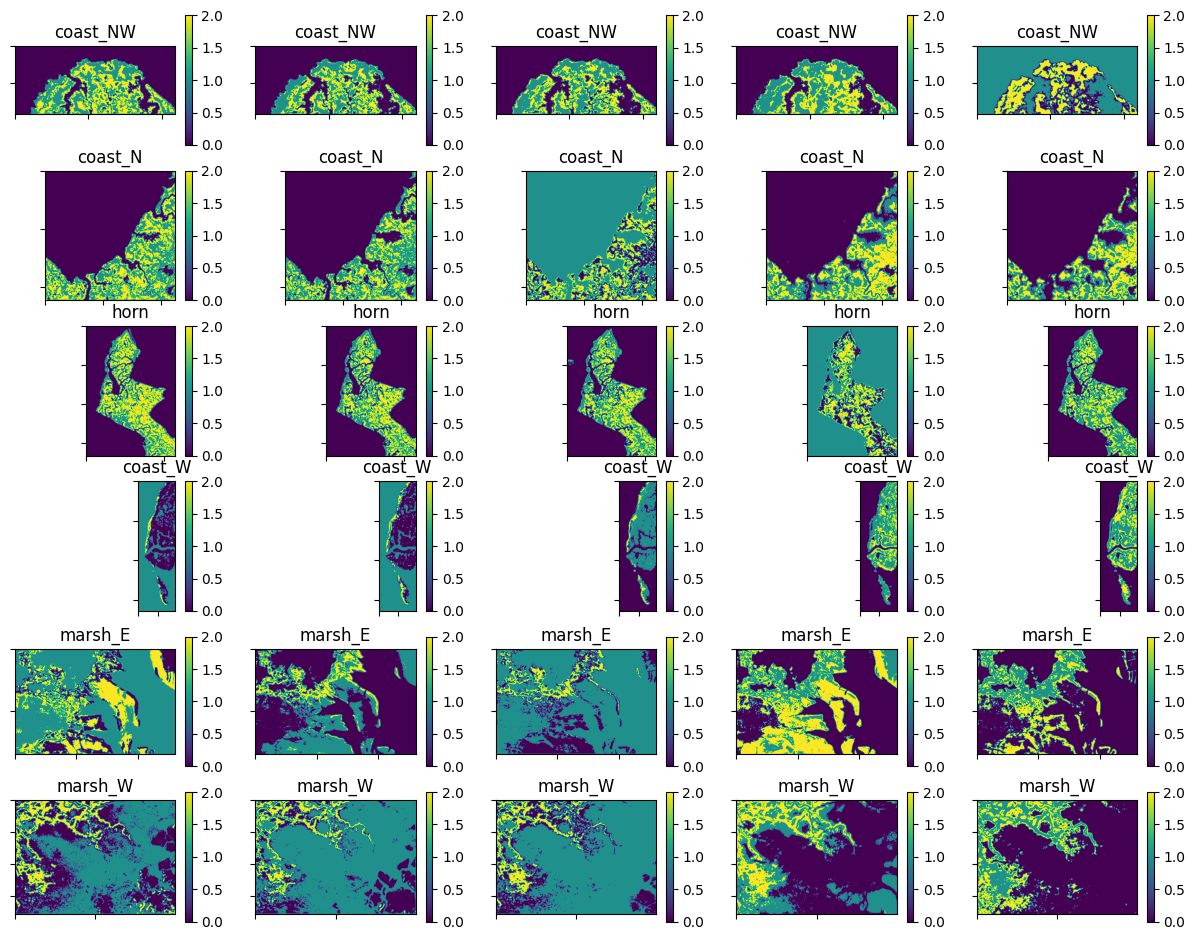

In [440]:
fig, axs = plt.subplots(6,5, figsize=(15,12), dpi=100)
axs = list(itertools.chain.from_iterable(axs))
count = 0
for j,blur in enumerate(blurredSites):
    for ob in blur:
        nd = axs[count].imshow(ob)
        axs[count].set_xticklabels([])
        axs[count].set_yticklabels([])
        axs[count].set_title(aoi_list[j])
        plt.colorbar(nd, ax = axs[count])
        count+=1
plt.show()


As I have not found a way to implement consistency on what is being categorized as 1 or 0s from Kmeans, I have manually determined what is being categorized as water (by plotting) and set up a matrix to mask out water iteratively in the next steps.

In [441]:
water_mask_matrix = [[0,0,0,0,1], [0,0,1,0,0], [0,0,0,1,0], [1,1,0,0,0], [1,0,1,0,0], [1,1,1,0,0]]
ground_mask_matrix = [[2,2,2,2,0], [2,2,2,1,1], [2,2,2,2,2], [2,2,2,2,2], [2,1,0,2,2], [0,0,0,1,2]]
#mask_matrix = [[0,1,0], [0,0,0], [0,0,0], [0, 1, 1, 0, 1], [0, 1, 0, 0, 0], [0, 1, 0, 1, 0]]

Matrix Masking
(This method seems good to visualize loss of coastline and mangrove cover, but does a poor job of showing mangrove advancing. Also, is not great in marsh_E AOI.)

In [442]:
maskSites = []
for i,blur in enumerate(blurredSites):
    shape = sites[i][-1].shape
    dim = (shape[2], shape[1])
    blur[0] = cv.resize(blur[0], dim, interpolation=cv.INTER_AREA)
    blur[1] = cv.resize(blur[1], dim, interpolation=cv.INTER_AREA)
    blur[2] = cv.resize(blur[2], dim, interpolation=cv.INTER_AREA)
    # Masking water out using mask matrix
    masks = [np.ma.masked_where(bl == water_mask_matrix[i][j], bl) for j,bl in enumerate(blur)]
    masks = [np.ma.masked_where(mask == ground_mask_matrix[i][j], mask) for j,mask in enumerate(masks)]
    #masks2 = [np.ma.masked_where(bl == ground_mask_matrix[i][j], bl) for j,bl in enumerate(masks1)]
    maskSites.append(masks)

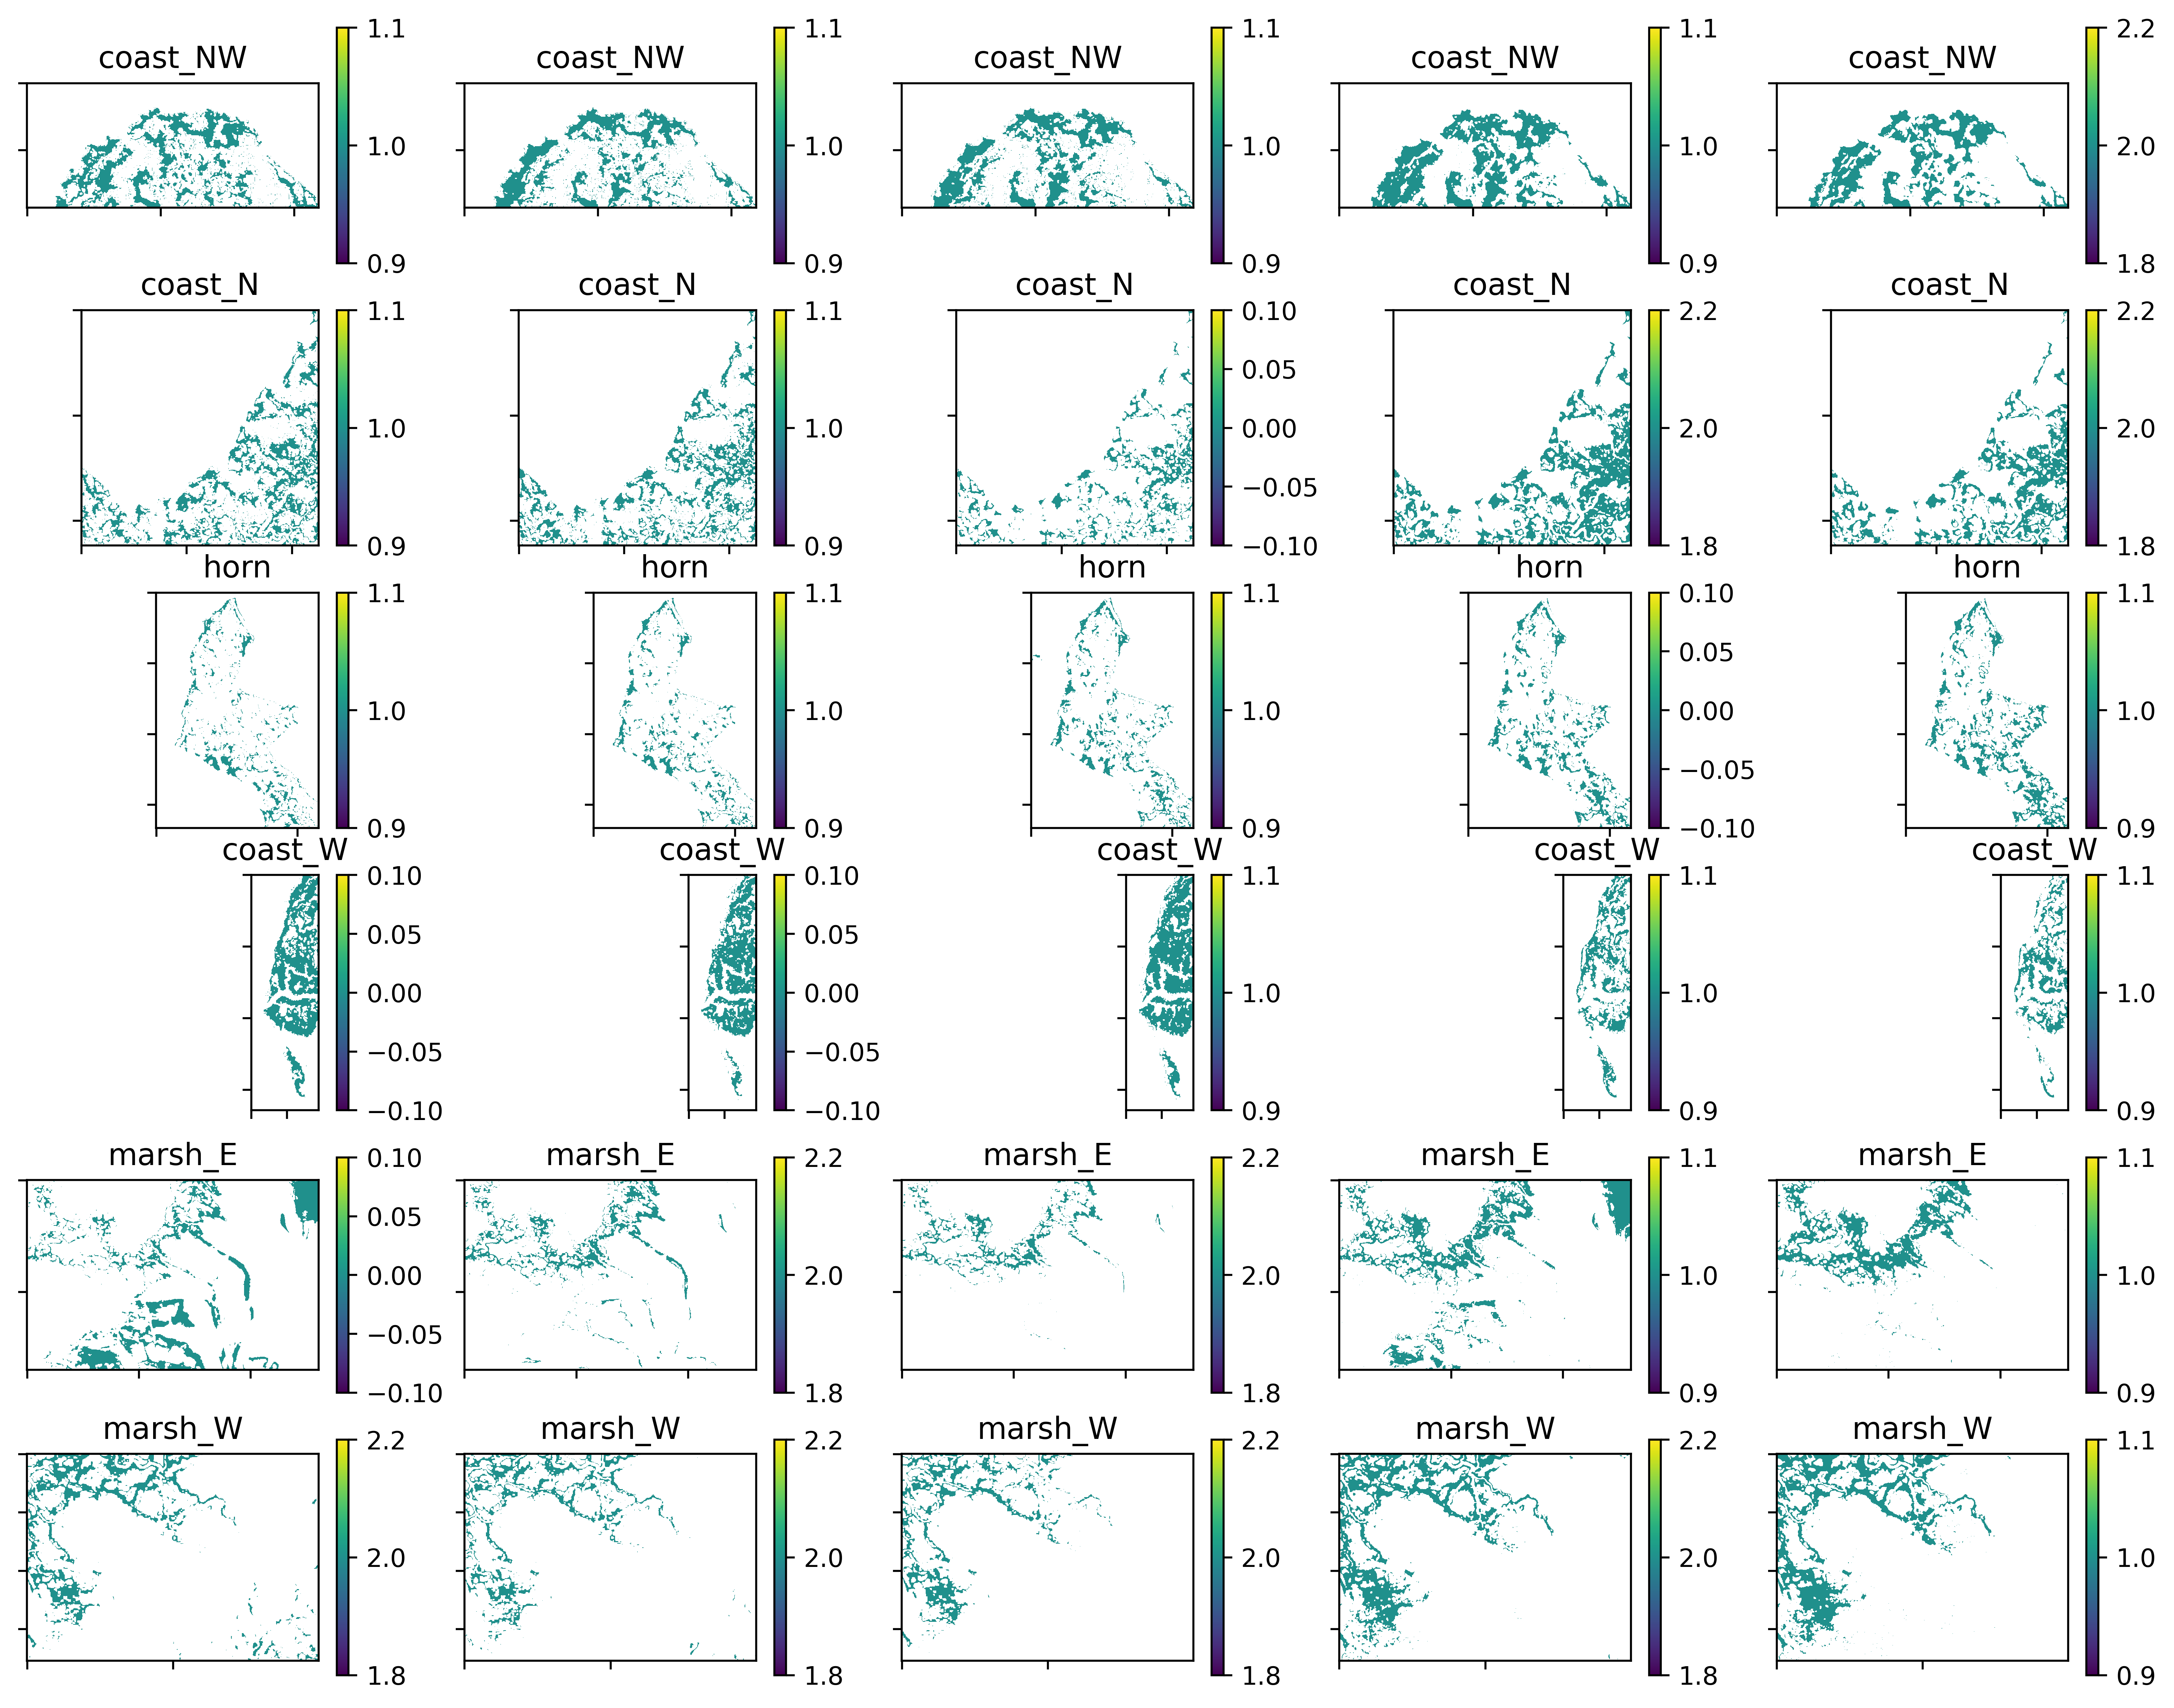

In [451]:
fig, axs = plt.subplots(6,5, figsize=(15,12), dpi=500)
axs = list(itertools.chain.from_iterable(axs))
count = 0
for j,blur in enumerate(maskSites):
    for ob in blur:
        nd = axs[count].imshow(ob)
        axs[count].set_xticklabels([])
        axs[count].set_yticklabels([])
        axs[count].set_title(aoi_list[j])
        plt.colorbar(nd, ax = axs[count])
        count+=1
plt.show()

Coastline and Mangrove Cover Change

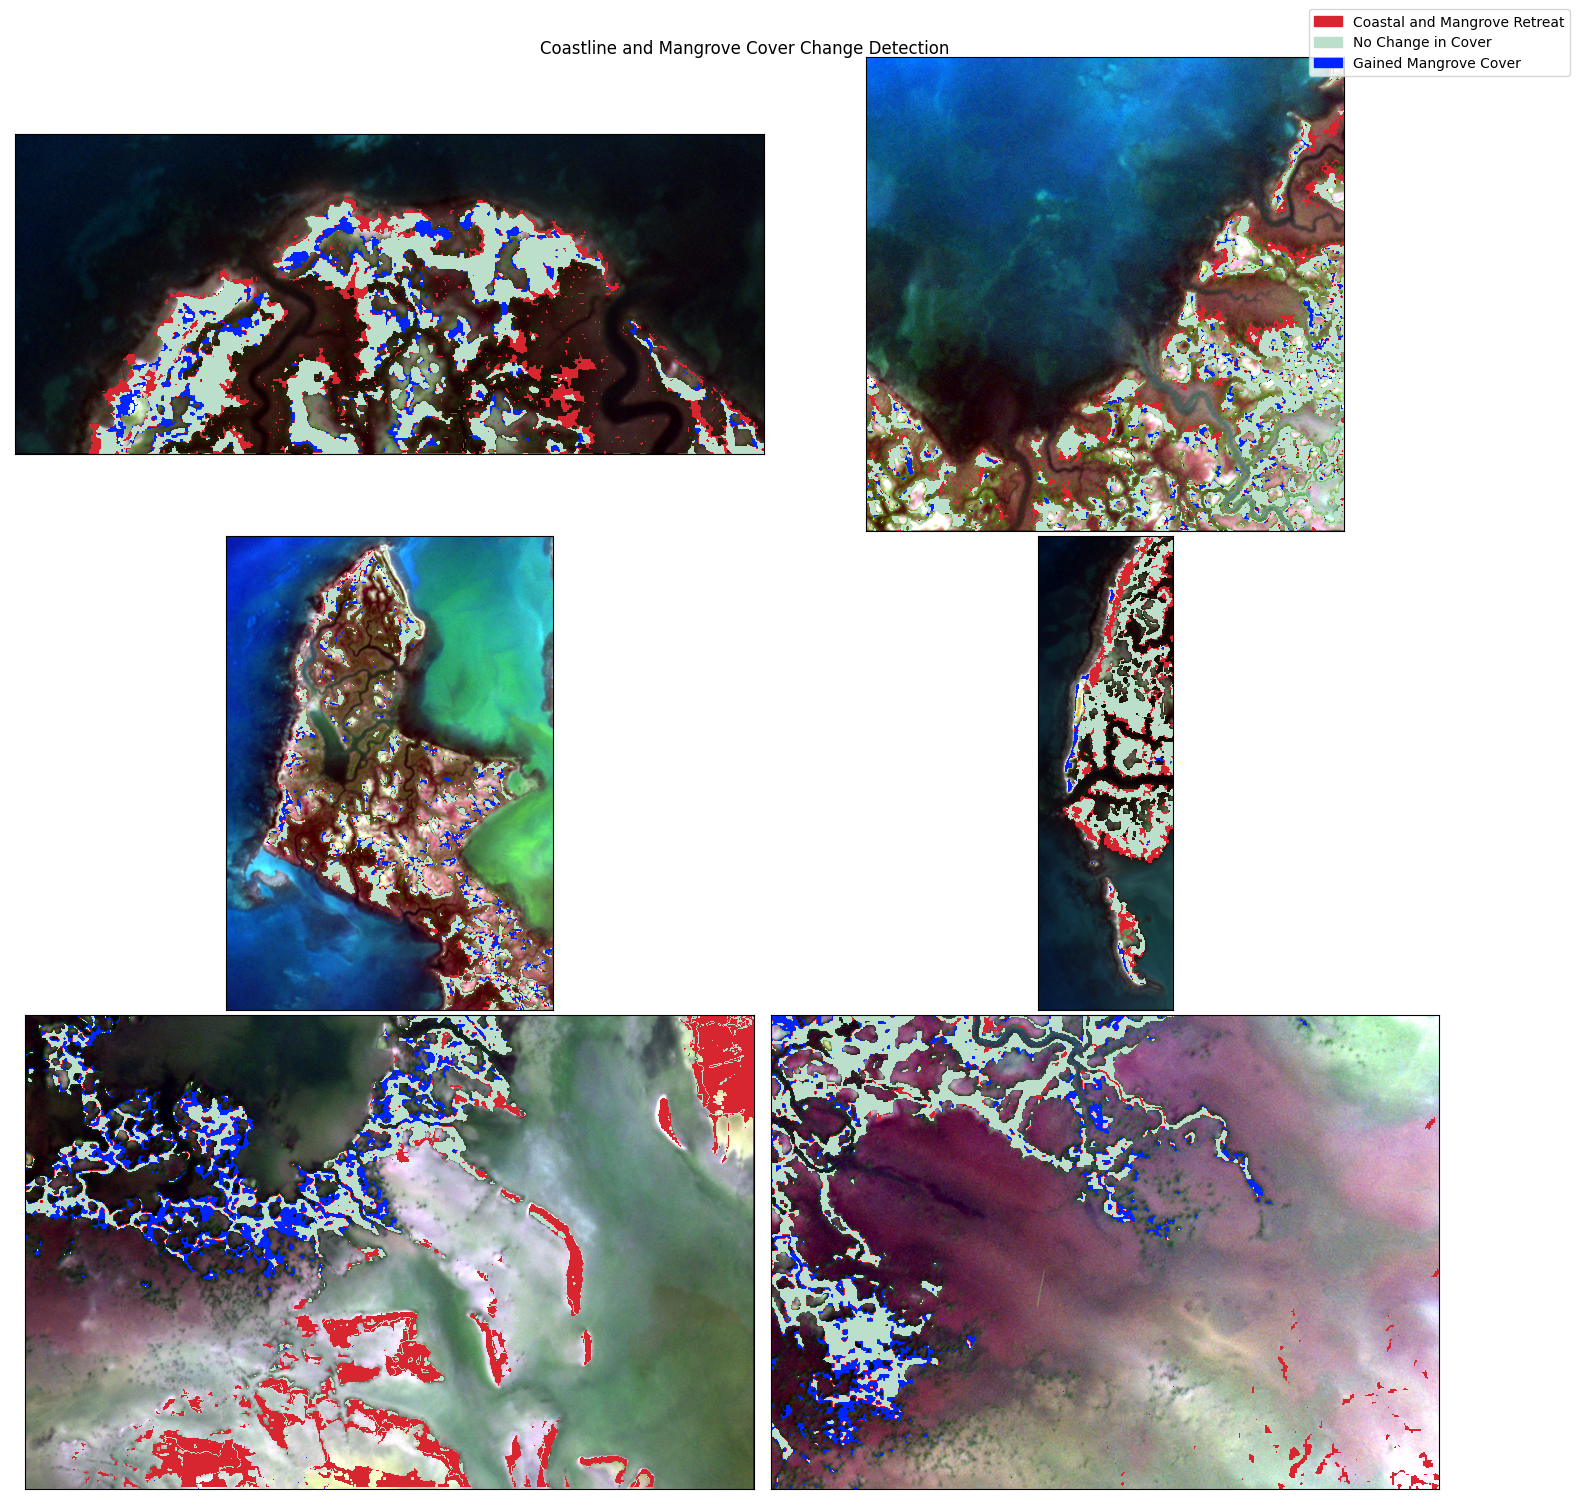

In [444]:
fig, axs = plt.subplots(3,2, figsize=(15,15), dpi=100)
axs = list(itertools.chain.from_iterable(axs))
custom_cmap = colors_mat.ListedColormap(['#0025FC', '#D7262F', '#BBDFCB'])
boundaries = [0, 2, 4, 6]
custom_norm = colors_mat.BoundaryNorm(boundaries, custom_cmap.N, clip=True)
#colors = [cm.get_cmap(value) for value in custom_cmap]

for i,site in enumerate(blurredSites):
    ep.plot_rgb(unmasked_sites[i][-1], rgb=[2,1,0], stretch=True,
            str_clip=.9, ax=axs[i])
    # Apply the blurred Image mask to NDVI !!!!!
    first = np.where(site[0] == maskSites[i][0], 4, 0)
    last = np.where(site[-1] == maskSites[i][-1], 2, 0)
    #first = maskSites[i][0]
    #last = maskSites[i][-1]
    change = first + last
    change_mask = np.ma.masked_where(change == 0, change)
    axs[i].imshow(change_mask, cmap=custom_cmap)

patches = [mpatches.Patch(color='#D7262F', label='Coastal and Mangrove Retreat'),
            mpatches.Patch(color='#BBDFCB', label='No Change in Cover'),
            mpatches.Patch(color='#0025FC', label='Gained Mangrove Cover')]
fig.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
fig.suptitle('Coastline and Mangrove Cover Change Detection')
fig.patch.set_facecolor('xkcd:white')
plt.tight_layout(h_pad=0,w_pad=0)
plt.show()

### Mangrove Extent Metrics

Counting Pixels to quantify gross mangrove cover loss.

In [445]:
pixelSites = []
for i, mask in enumerate(maskSites):
    pixels = [np.size(m.mask) - np.count_nonzero(m.mask) for m in mask]
    pixelSites.append(pixels)

changeSites = []
percChangeSites = []
for i, pixels in enumerate(pixelSites):
    surfaces = [(3**2)*pixels[j] for j, res in enumerate(resSites[i])]
    change = (surfaces[-1] - surfaces[0])/(1e6)
    percent = (change*100)/(surfaces[0]/1e6)
    changeSites.append(change)
    percChangeSites.append(percent)

df_change = pd.DataFrame({'AOI': aoi_list,
                'Cover Change (km^2)': changeSites,
                'Percent Change (%)': percChangeSites})
df_change

AOI  Cover Change (km^2)  Percent Change (%)
0  coast_NW            -0.166680          -16.418585
1   coast_N            -0.388800          -18.750977
2      horn             0.522144           24.250227
3   coast_W            -0.753957          -32.589777
4   marsh_E            -0.075033           -4.952212
5   marsh_W             0.381555           53.105271

2nd Moment of Area  against x-axis for Cover + Sparsity Change

In [446]:
secMOAs = []
changeMOA = []
percMOA = []

for j in range(5):
    moa_yr = []
    for i, site in enumerate(maskSites):
        pixels = [np.size(row) - np.count_nonzero(row) for row in site[j]]
        distances = [3*(site[j].shape[0] - 1 - k) for k in range(len(site[j]))]
        moa = 0
        for l,pixel in enumerate(pixels):
            moa += (3**2)*pixel * distances[l]**2 
        moa_yr.append(moa)
    secMOAs.append(moa_yr)


changeMOA = [secMOAs[-1][i] - secMOAs[0][i] for i in range(len(secMOAs[0]))]
percMOA = [(change*100)/(secMOAs[0][i]) for i, change in enumerate(changeMOA)]
    
df_MOA = pd.DataFrame({'AOI': aoi_list, 'Y1': secMOAs[:][0], 'Y2': secMOAs[:][1], 'Y3': secMOAs[:][2], 'Y4': secMOAs[:][3], 'Y5': secMOAs[:][4],
                '2MOAx Change (2022-2012)': changeMOA,
                '2MOAx Percent Change (%)': percMOA})

df_MOA

AOI               Y1               Y2               Y3  \
0  coast_NW    2392000598061    2431352349513    2406176732871   
1   coast_N   36649714958613   37340655509187    1426406401575   
2      horn  107862891412158  109485209241738  108920420422749   
3   coast_W   22034070626085   20905538889024   31024715099346   
4   marsh_E    3411317492694   13313676789153    3422316053718   
5   marsh_W    3302084482128    1416864045834    1910373315588   

               Y4               Y5  2MOAx Change (2022-2012)  \
0   2410824919410     188618842647            -2203381755414   
1  37154800641609   38470631918589             1820916959976   
2  12764568757086  108972410044410             1109518632252   
3  28203318807318   28453971843000             6419901216915   
4  11214192776886   13838397521283            10427080028589   
5   4750031205846    5473224573426             2171140091298   

   2MOAx Percent Change (%)  
0                -92.114599  
1                  4.968434  
2                  1.028638  
3                 29.136247  
4                305.661377  
5                 65.750592

2nd Moment of Area  against y-axis for Cover + Sparsity Change

In [447]:
secMOAs_y = []
changeMOA_y = []
percMOA_y = []

for j in range(5):
    moa_yr = []
    for i, site in enumerate(maskSites):
        pixels = [np.size(col) - np.count_nonzero(col) for col in site[j].T]
        distances = [3*((site[j].T).shape[0] - 1 - k) for k in range(len(site[j].T))]
        moa = 0
        for l,pixel in enumerate(pixels):
            moa += (3**2)*pixel * distances[l]**2 
        moa_yr.append(moa)
    secMOAs_y.append(moa_yr)


changeMOA_y = [secMOAs_y[-1][i] - secMOAs_y[0][i] for i in range(len(secMOAs_y[0]))]
percMOA_y = [(change*100)/(secMOAs_y[0][i]) for i, change in enumerate(changeMOA_y)]
    
df_MOA = pd.DataFrame({'AOI': aoi_list, 'Y1': secMOAs_y[:][0], 'Y2': secMOAs_y[:][1], 'Y3': secMOAs_y[:][2], 'Y4': secMOAs_y[:][3], 'Y5': secMOAs_y[:][4],
                '2MOAy Change (2022-2012)': changeMOA_y,
                '2MOAy Percent Change (%)': percMOA_y})

df_MOA

AOI              Y1              Y2              Y3              Y4  \
0  coast_NW  10777279163985  11180369860497  11018974926933  10907498283192   
1   coast_N  33349425557337  33881211608913   2614753730736  33515316349326   
2      horn  50512255142013  51540848603685  51501589467876   6359757199461   
3   coast_W    642800257650    568476197136   3825740756565   3760762693455   
4   marsh_E   7385484566529  29086866188802  11531395059327  21720579243057   
5   marsh_W   8266861707156   4217867527005   5322184961013   6471987693435   

               Y5  2MOAy Change (2022-2012)  2MOAy Percent Change (%)  
0   1881823155435            -8895456008550                -82.538977  
1  34760672319267             1411246761930                  4.231697  
2  51601847880780             1089592738767                  2.157086  
3   3734312737914             3091512480264                480.944499  
4  28898747037585            21513262471056                291.291144  
5   8040558724371             -226302982785                 -2.737471

## dNDVI Analysis

In [448]:
ndviSites = []
for site in sites:
    obs_ndvi = [site[0], site[-1]]
    ndvi = []
    for ob in obs_ndvi:
        red = ob[2]#.fillna(-999)
        try:
            nir = ob[4]#.fillna(-999)
        except:
            nir = ob[3]
        nd = ((nir - red)/(nir + red))#.fillna(-999)
        ndvi.append(nd) 
    ndviSites.append(ndvi)
    

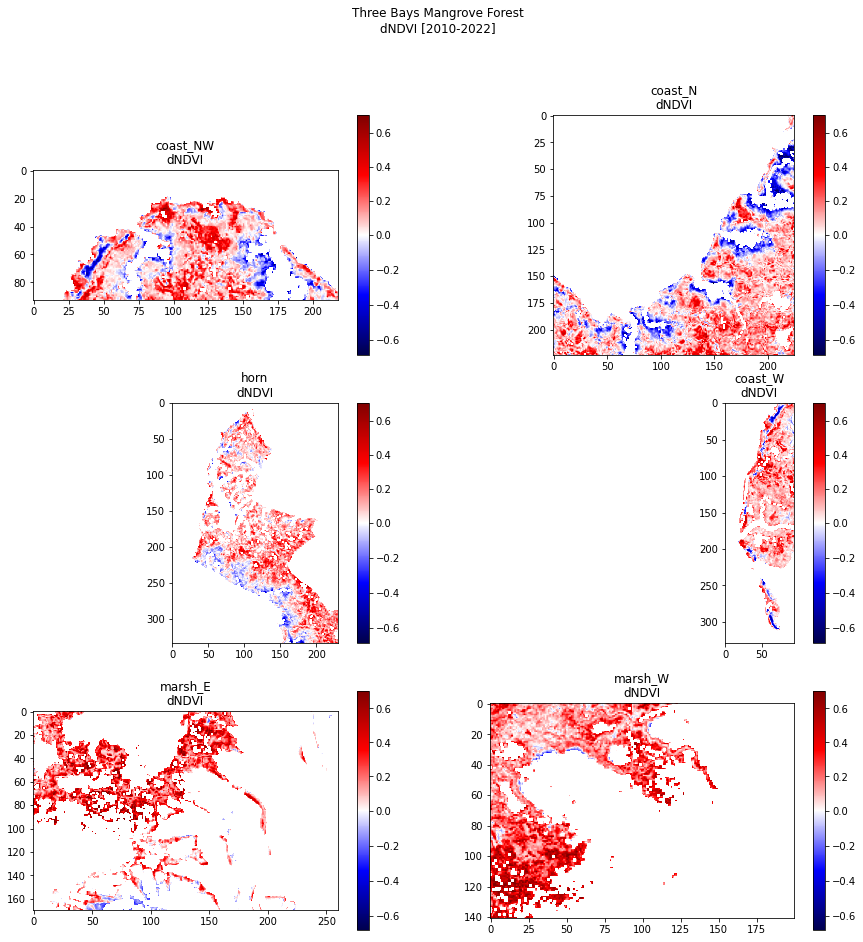

In [449]:
dndvi = [ndvi[1] - ndvi[0] for ndvi in ndviSites]

fig, axs = plt.subplots(3,2, figsize=(15,15))

fig.suptitle("Three Bays Mangrove Forest\ndNDVI [2010-2022]")
axs = list(itertools.chain.from_iterable(axs))
cmaps = ['Set1', 'Pastel2']
divnorm = colors_mat.TwoSlopeNorm(vcenter=0)

for i,diff in enumerate(dndvi):
    #colors = ["darkorange", "black", "lawngreen"]
    #cmap1 = LinearSegmentedColormap.from_list('viridis', colors)
    nd = axs[i].imshow(diff, cmap='seismic', norm=divnorm)
    axs[i].set_title(aoi_list[i]+'\ndNDVI')
    plt.colorbar(nd, ax=axs[i])

plt.show()